In [5]:
# ================================
# 1. Imports & basic configuration
# ================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import scipy

from scipy.ndimage import median_filter
from scipy.signal import find_peaks

plt.style.use("default")  # keep plots clean

# Path to the Dips + Pull-ups CSV file (relative to this notebook)
DATA_PATH = Path("..") / "data" / "Dips_PU.csv"

print("Using data file:", DATA_PATH)

# ENMO smoothing parameters
MEDIAN_FILTER_SIZE = 5          # samples
MOVING_AVERAGE_WINDOW_S = 0.2   # seconds

# Dips & pull-ups repetition detection parameters
EXERCISE_PARAMS = {
    "Dips": {
        "min_interval_s": 1.3,   # dips are faster
        "percentile": 88,        # amplitude threshold (adaptive)
    },
    "Pull-ups": {
        "min_interval_s": 2.0,   # pull-ups slower
        "percentile": 85,
    },
}

Using data file: ../data/Dips_PU.csv


In [6]:
# =======================================
# 2. Load raw accelerometer data from CSV
# =======================================

def load_acc_csv(path: str) -> pd.DataFrame:
    """
    Load accelerometer data exported from OmGui.

    Assumes CSV has no header and columns are:
        0: timestamp (string)
        1: Ax
        2: Ay
        3: Az

    Returns a DataFrame with:
        - timestamp (datetime)
        - t (seconds from start)
        - Ax, Ay, Az (float)
    """
    df = pd.read_csv(path, header=None)
    df.columns = ["timestamp", "Ax", "Ay", "Az"]

    df["timestamp"] = pd.to_datetime(df["timestamp"])
    t0 = df["timestamp"].iloc[0]
    df["t"] = (df["timestamp"] - t0).dt.total_seconds()

    return df


df_raw = load_acc_csv(DATA_PATH)

print("Number of samples:", len(df_raw))
print("Recording time span:", df_raw["timestamp"].iloc[0], "->", df_raw["timestamp"].iloc[-1])
print("Duration (s):", df_raw["t"].iloc[-1])
df_raw.head()

Number of samples: 18000
Recording time span: 2025-11-27 19:00:06.929000 -> 2025-11-27 19:03:01.720000
Duration (s): 174.791


,timestamp,Ax,Ay,Az,t
0,2025-11-27 19:00:06.929,0.031250,-1.031250,0.093750,0.000
1,2025-11-27 19:00:06.939,0.015625,-0.171875,0.546875,0.010
2,2025-11-27 19:00:06.949,0.000000,-0.078125,0.375000,0.020
3,2025-11-27 19:00:06.960,0.000000,-0.046875,0.171875,0.031
4,2025-11-27 19:00:06.969,-0.109375,-0.109375,0.046875,0.040


In [7]:
# ===================================
# 3. Estimate sampling frequency (Hz)
# ===================================

def estimate_sampling_frequency(df: pd.DataFrame) -> float:
    dts = df["timestamp"].diff().dt.total_seconds().dropna()
    fs = 1.0 / dts.mean()
    return fs


fs = estimate_sampling_frequency(df_raw)
print(f"Estimated sampling frequency: {fs:.2f} Hz")


Estimated sampling frequency: 102.97 Hz


In [8]:
# ===================================================
# 4. Define time windows for Dips and Pull-ups (s)
# ===================================================

# extract date of recording and first timestamp
date0 = df_raw["timestamp"].iloc[0].date()
t0 = df_raw["timestamp"].iloc[0]

def rel_t(h: int, m: int, s: int) -> float:
    """
    Convert absolute clock time (h:m:s) on the recording day
    into relative seconds from the beginning of the file.
    """
    dt = pd.Timestamp(year=date0.year, month=date0.month, day=date0.day,
                      hour=h, minute=m, second=s)
    return (dt - t0).total_seconds()

# ---- CORRECT WINDOWS ----
# Dips: start at 19:00:00, duration 55 s
DIPS_START_S = rel_t(19, 0, 0)
DIPS_END_S   = DIPS_START_S + 55.0

# Pull-ups: start at 19:02:00, duration 39 s
PU_START_S = rel_t(19, 2, 0)
PU_END_S   = PU_START_S + 39.0

print(f"Dips window:     {DIPS_START_S:.1f} s -> {DIPS_END_S:.1f} s "
      f"(duration {DIPS_END_S - DIPS_START_S:.1f} s)")
print(f"Pull-ups window: {PU_START_S:.1f} s -> {PU_END_S:.1f} s "
      f"(duration {PU_END_S - PU_START_S:.1f} s)")



Dips window:     -6.9 s -> 48.1 s (duration 55.0 s)
Pull-ups window: 113.1 s -> 152.1 s (duration 39.0 s)


In [ ]:
# ==========================================
# 5. Extract Dips and Pull-ups data windows
# ==========================================

df_dips = df_raw[(df_raw["t"] >= DIPS_START_S) & (df_raw["t"] <= DIPS_END_S)].copy()
df_pu   = df_raw[(df_raw["t"] >= PU_START_S)   & (df_raw["t"] <= PU_END_S)].copy()

# --- Remove the first X seconds inside the pull-ups window ---
CUT_FIRST_SECONDS_PU = 5.7   # essaie 7 ou 8 s si le pic est vers 5 s

t0_pu = df_pu["t"].iloc[0]
df_pu = df_pu[df_pu["t"] - t0_pu >= CUT_FIRST_SECONDS_PU].copy()

# re-zero time inside the pull-ups window (optional but cleaner)
df_pu["t"] = df_pu["t"] - df_pu["t"].iloc[0]

print("Dips samples:", len(df_dips), "| duration (s):", 
      df_dips["t"].iloc[-1] - df_dips["t"].iloc[0])
print("Pull-ups samples:", len(df_pu), "| duration (s):",
      df_pu["t"].iloc[-1] - df_pu["t"].iloc[0])


Dips samples: 4947 | duration (s): 48.064
Pull-ups samples: 3429 | duration (s): 33.282


In [14]:
# ==========================================
# 6. Compute ENMO and apply smoothing
# ==========================================

def compute_enmo(df: pd.DataFrame) -> pd.DataFrame:
    """
    Compute Euclidean Norm Minus One (ENMO):
        ENMO = max( sqrt(Ax^2 + Ay^2 + Az^2) - 1, 0 )
    """
    ax = df["Ax"].values
    ay = df["Ay"].values
    az = df["Az"].values
    """"""
    enmo = np.sqrt(ax**2 + ay**2 + az**2) - 1.0
    enmo[enmo < 0] = 0.0
    df["ENMO"] = enmo
    return df


def smooth_enmo(df: pd.DataFrame, fs: float,
                median_size: int = 5,
                ma_window_s: float = 0.2) -> pd.DataFrame:
    """
    Apply median filter + moving average to ENMO.
    Adds 'ENMO_smooth'.
    """
    enmo = df["ENMO"].values

    # median filter to remove spikes
    enmo_med = median_filter(enmo, size=median_size)

    # moving average over ma_window_s seconds
    kernel_len = max(3, int(ma_window_s * fs))
    enmo_smooth = (
        pd.Series(enmo_med)
        .rolling(window=kernel_len, center=True, min_periods=1)
        .mean()
        .values
    )

    df["ENMO_smooth"] = enmo_smooth
    return df


# apply to both windows
df_dips = smooth_enmo(compute_enmo(df_dips), fs,
                      median_size=MEDIAN_FILTER_SIZE,
                      ma_window_s=MOVING_AVERAGE_WINDOW_S)

df_pu   = smooth_enmo(compute_enmo(df_pu), fs,
                      median_size=MEDIAN_FILTER_SIZE,
                      ma_window_s=MOVING_AVERAGE_WINDOW_S)

df_dips[["t", "ENMO", "ENMO_smooth"]].head()


,t,ENMO,ENMO_smooth
0,0.000,0.035974,0.0
1,0.010,0.000000,0.0
2,0.020,0.000000,0.0
3,0.031,0.000000,0.0
4,0.040,0.000000,0.0


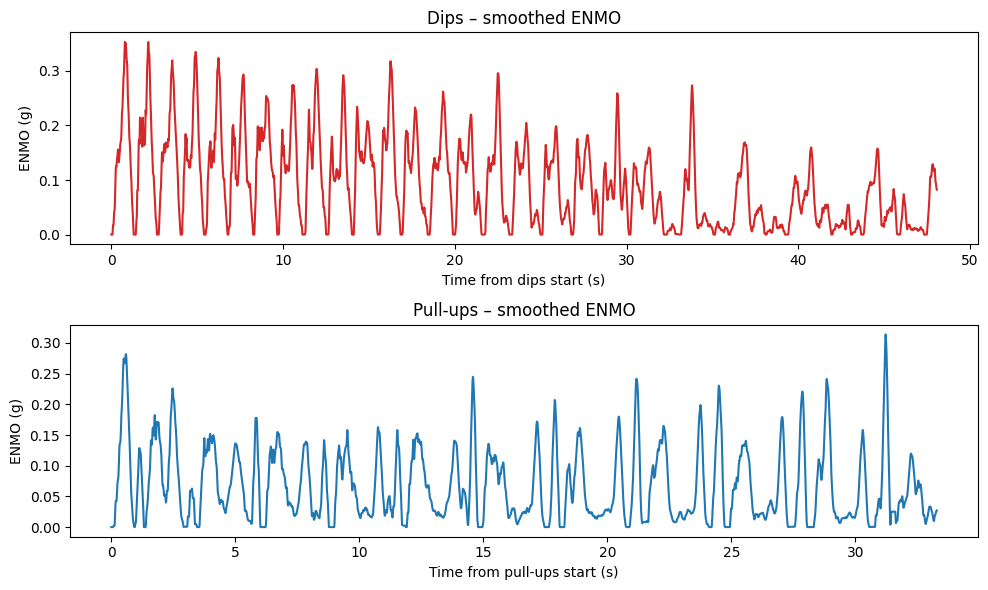

In [ ]:
# ======================================
# 7. Visualise smoothed ENMO per exercise
# ======================================

fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=False)

axes[0].plot(df_dips["t"] - df_dips["t"].iloc[0],
             df_dips["ENMO_smooth"], color="tab:red")
axes[0].set_title("Dips – smoothed ENMO")
axes[0].set_ylabel("ENMO (g)")
axes[0].set_xlabel("Time from dips start (s)")

axes[1].plot(df_pu["t"] - df_pu["t"].iloc[0], 
             df_pu["ENMO_smooth"], color="tab:blue")
axes[1].set_title("Pull-ups – smoothed ENMO")
axes[1].set_ylabel("ENMO (g)")
axes[1].set_xlabel("Time from pull-ups start (s)")

plt.tight_layout()
plt.show()
